In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
 # only using 2011-19, to maintain consistent passer IDs
pbp = pd.concat([pd.read_csv(f'pbp_data/play_by_play_{season}.csv.gz', compression='gzip', low_memory=False) for season in range(2011,2020)])

In [3]:
passes = pbp.loc[pbp.pass_attempt==1].copy()
passes['ayts'] = passes['air_yards']-passes['ydstogo']

In [4]:
ayts = passes.groupby(['season','passer_id']).agg({'play_id':'count'})
for index,down in enumerate(['first','second','third']):
    ayts[f'{down}_down_ayts'] = passes.loc[passes.down==(index+1)].groupby(['season','passer_id']).agg({'ayts':'mean'})
ayts['early_down_ayts'] = passes.loc[passes.down.isin([1,2])].groupby(['season','passer_id']).agg({'ayts':'mean'})
ayts['overall_ayts'] = passes.groupby(['season','passer_id']).agg({'ayts':'mean'})
ayts = ayts.loc[ayts.play_id>=128].reset_index()
ayts.head()

,season,passer_id,play_id,first_down_ayts,second_down_ayts,third_down_ayts,early_down_ayts,overall_ayts
0,2011,32013030-2d30-3030-3730-39316c93ae22,536,-1.770492,-2.226415,0.260355,-1.982456,-1.218569
1,2011,32013030-2d30-3031-3130-3232b50875be,172,-3.264151,0.019231,0.437500,-1.638095,-0.903846
2,2011,32013030-2d30-3031-3935-39361b587621,755,-1.273016,-0.105485,1.839506,-0.771739,-0.159722
3,2011,32013030-2d30-3032-3032-3435b1d69a2f,441,-1.101064,0.991736,1.650485,-0.281553,0.210526
4,2011,32013030-2d30-3032-3035-33318e1e348d,791,-2.213415,0.027027,0.573964,-1.224872,-0.832675


In [5]:
# I stole this code from @EthanCDouglas and modified it a bit
def year_to_year_corr(columns, groupby, data):
    cols = [groupby, 'season'] + columns 
    data = data[cols]
    ldata = data.groupby(by=groupby).shift(-1)
    data.columns = [groupby, 'prev_season'] + [f'prev_{col}' for col in columns]
    new_data = pd.concat((data, ldata), axis=1).dropna(subset=['season']).drop(columns=['prev_season','season'])
    tot_corr = new_data.corr(method='pearson')
    num_corr_cols = len(columns)
    corr = tot_corr.iloc[num_corr_cols:,num_corr_cols:]
    pred = tot_corr.iloc[0:num_corr_cols, num_corr_cols:]
    return new_data,corr,pred

yoy_ayts_changes,ayts_corr,ayts_pred = year_to_year_corr(['first_down_ayts','second_down_ayts','third_down_ayts','early_down_ayts','overall_ayts'],'passer_id',ayts)

In [6]:
ayts_pred**2

,first_down_ayts,second_down_ayts,third_down_ayts,early_down_ayts,overall_ayts
prev_first_down_ayts,0.128733,0.023829,0.000550,0.110003,0.076666
prev_second_down_ayts,0.016603,0.054330,0.022427,0.046364,0.056524
prev_third_down_ayts,0.004661,0.017831,0.222703,0.000485,0.039556
prev_early_down_ayts,0.099260,0.054293,0.004483,0.118550,0.102170
prev_overall_ayts,0.051920,0.058306,0.055849,0.082387,0.114059


In [7]:
adot = passes.groupby(['season','passer_id']).agg({'play_id':'count'})
for index,down in enumerate(['first','second','third']):
    adot[f'{down}_down_adot'] = passes.loc[passes.down==(index+1)].groupby(['season','passer_id']).agg({'air_yards':'mean'})
adot['early_down_adot'] = passes.loc[passes.down.isin([1,2])].groupby(['season','passer_id']).agg({'air_yards':'mean'})
adot['overall_adot'] = passes.groupby(['season','passer_id']).agg({'air_yards':'mean'})
adot = adot.loc[adot.play_id>=128].reset_index()

In [8]:
yoy_adot_changes,adot_corr,adot_pred = year_to_year_corr(['first_down_adot','second_down_adot','third_down_adot','early_down_adot','overall_adot'],'passer_id',adot)

In [9]:
adot_pred**2

,first_down_adot,second_down_adot,third_down_adot,early_down_adot,overall_adot
prev_first_down_adot,0.138661,0.069996,0.000020,0.150046,0.102454
prev_second_down_adot,0.054615,0.104746,0.027952,0.099516,0.100939
prev_third_down_adot,0.000014,0.037587,0.217003,0.009581,0.062286
prev_early_down_adot,0.135086,0.115619,0.008675,0.175180,0.141520
prev_overall_adot,0.088994,0.122484,0.058431,0.141796,0.157114


Text(0.5, 1.0, 'Year over Year Changes in Average Depth of Target by Down')

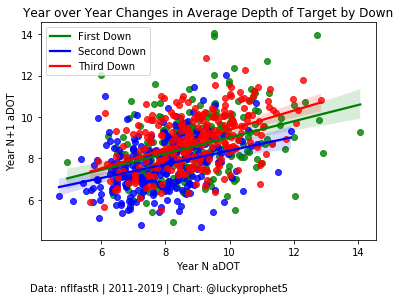

In [10]:
fig,ax = plt.subplots()
downs = ["first","second","third"]
colors = ["g","b","r"]
for i in range(3):
    sns.regplot(x=f"prev_{downs[i]}_down_adot", y=f"{downs[i]}_down_adot", data=yoy_adot_changes, ax=ax, color=colors[i])
ax.legend(["First Down", "Second Down", "Third Down"])
ax.set_xlabel("Year N aDOT")
ax.set_ylabel("Year N+1 aDOT")
plt.figtext(0.1,-0.05,"Data: nflfastR | 2011-2019 | Chart: @luckyprophet5")
ax.set_title("Year over Year Changes in Average Depth of Target by Down")

Text(0.5, 1.0, 'Year over Year Changes in Average Air Yards to Sticks by Down')

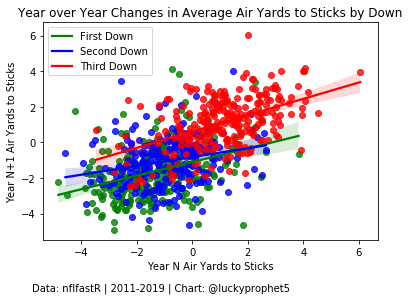

In [11]:
fig,ax = plt.subplots()
downs = ["first","second","third"]
colors = ["g","b","r"]
for i in range(3):
    sns.regplot(x=f"prev_{downs[i]}_down_ayts", y=f"{downs[i]}_down_ayts", data=yoy_ayts_changes, ax=ax, color=colors[i])
ax.legend(["First Down", "Second Down", "Third Down"])
ax.set_xlabel("Year N Air Yards to Sticks")
ax.set_ylabel("Year N+1 Air Yards to Sticks")
plt.figtext(0.1,-0.05,"Data: nflfastR | 2011-2019 | Chart: @luckyprophet5")
ax.set_title("Year over Year Changes in Average Air Yards to Sticks by Down")

Text(0.5, 1, 'Year to Year R^2, air yards to sticks')

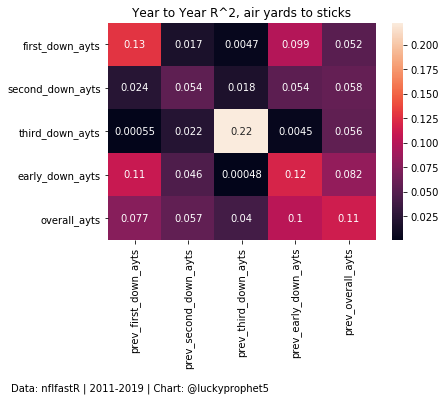

In [12]:
sns.heatmap(ayts_pred.transpose()**2, annot=True)
plt.figtext(-0.1,-.4,"Data: nflfastR | 2011-2019 | Chart: @luckyprophet5")
plt.title("Year to Year R^2, air yards to sticks")

Text(0.5, 1, 'Year to Year R^2, average depth of target')

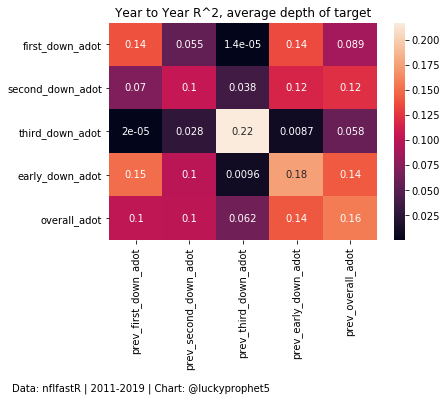

In [13]:
sns.heatmap(adot_pred.transpose()**2, annot=True)
plt.figtext(-0.1,-.4,"Data: nflfastR | 2011-2019 | Chart: @luckyprophet5")
plt.title("Year to Year R^2, average depth of target")

Text(0.5, 1, 'R^2, average depth of target by down')

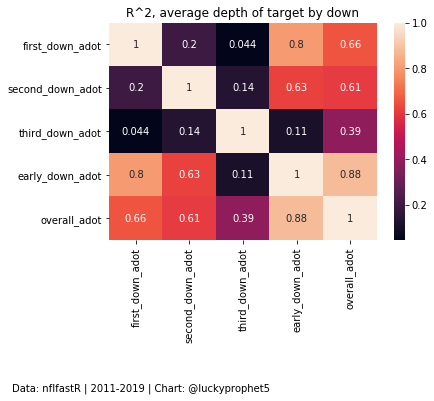

In [14]:
sns.heatmap(adot_corr**2, annot=True)
plt.figtext(-0.1,-.4,"Data: nflfastR | 2011-2019 | Chart: @luckyprophet5")
plt.title("R^2, average depth of target by down")

Text(0.5, 1, 'R^2, average air yards to sticks by down')

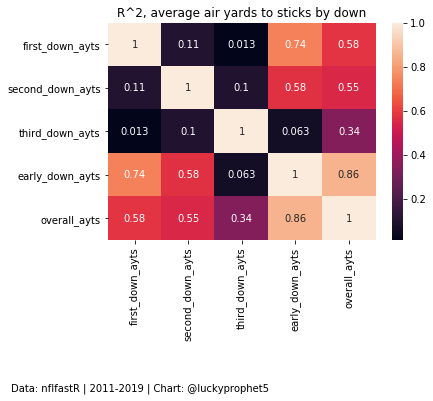

In [15]:
sns.heatmap(ayts_corr**2, annot=True)
plt.figtext(-0.1,-.4,"Data: nflfastR | 2011-2019 | Chart: @luckyprophet5")
plt.title("R^2, average air yards to sticks by down")